#### **Phase-Amplitude Coupling Documentation**

##### **Step 1: Hilbert Transformation**
**This step extracts the instantaneous phase and amplitude of oscillations**

1. **Discrete Fourier Transform (DFT)**:
   $\displaystyle X[k] = \sum_{n=0}^{N-1} x[n] e^{-j \frac{2\pi k n}{N}}$

2. **Hilbert Transform Filter**:
   $$
   \displaystyle H[k] =
   \displaystyle \begin{cases} 
   \displaystyle 1 & \text{if } k = 0 \text{ (DC component)} \\
   \displaystyle 2 & \text{if } 1 \leq k < \frac{N}{2} \text{ (positive frequencies)} \\
   \displaystyle 1 & \text{if } k = \frac{N}{2} \text{ (Nyquist frequency, for even } N\text{)} \\
   \displaystyle 0 & \text{otherwise (negative frequencies)}
   \displaystyle \end{cases}
   $$

3. **Inverse Discrete Fourier Transform (IDFT)**:
   $\displaystyle x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] e^{j \frac{2\pi k n}{N}}$

4. **Analytic Signal**:
   $\displaystyle z[n] = \text{IDFT}(\text{DFT}(x[n]) \cdot H[k])$

**Output**:

- **Instantaneous Amplitude**: $A[n] = |z[n]| = \sqrt{\text{Re}(z[n])^2 + \text{Im}(z[n])^2}$

- **Instantaneous Phase**: $\displaystyle \phi[n] = \text{arg}(z[n]) = \arctan\left(\frac{\text{Im}(z[n])}{\text{Re}(z[n])}\right)$

##### **Step 2: Phase-Amplitude Coupling**

**This step calculates the preferred phase and mean vector length (coupling strength)**

1. **Mapping**:
   Extract the SO phase corresponding to the spindle peak instantaneous amplitude.

2. **Preferred Phase**:
   $\theta = \arctan2\left(\sum_{j=1}^n \sin(\theta_j), \sum_{j=1}^n \cos(\theta_j)\right)$

3. **Mean Vector Length**:
   $\displaystyle R = \frac{1}{n} \sqrt{\left(\sum_{j=1}^n \sin(\theta_j)\right)^2 + \left(\sum_{j=1}^n \cos(\theta_j)\right)^2}$

4. **Uniformity Testing**:
   $z = N \cdot R^2$, where $N$ is the number of data points, $p \approx e^{-z} (1 + z)$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import butter, filtfilt
from scipy.stats import circmean, zscore

Analytic Signal (Real + Imaginary Part):
['-0.000000-0.013752j', '0.022897-0.026276j', '0.062667+0.000661j', '0.059987+0.070648j', '-0.015708+0.122895j'] ...
Instantaneous phase [-1.57079633 -0.85400248  0.01054099  0.8668271   1.69792729] ...
Instantaneous amplitude [0.01375193 0.03485308 0.0626701  0.09267986 0.12389439] ...


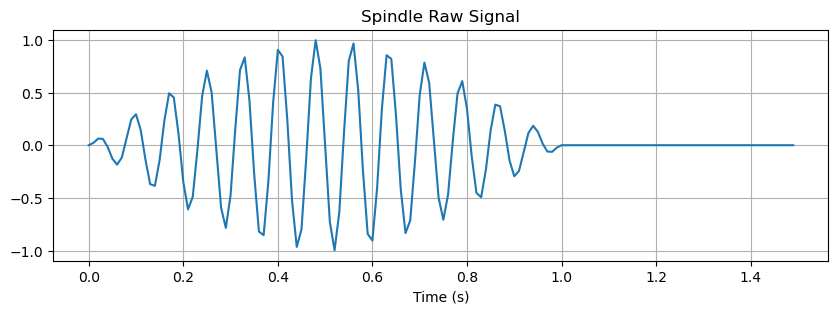

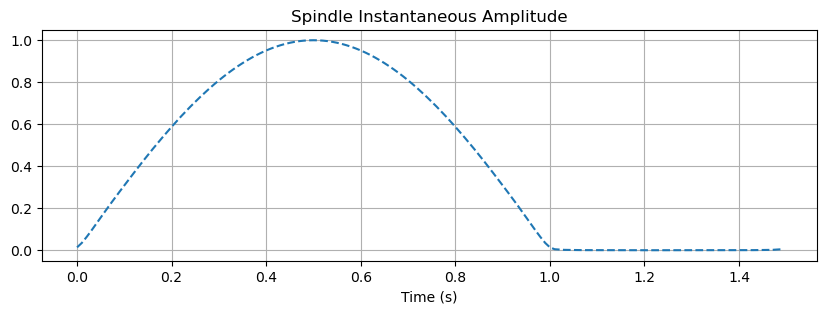

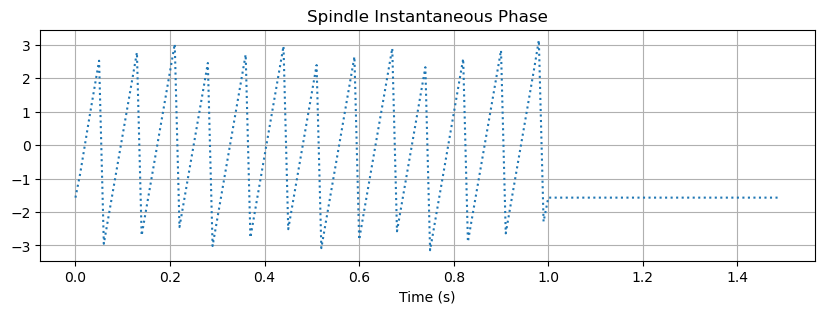

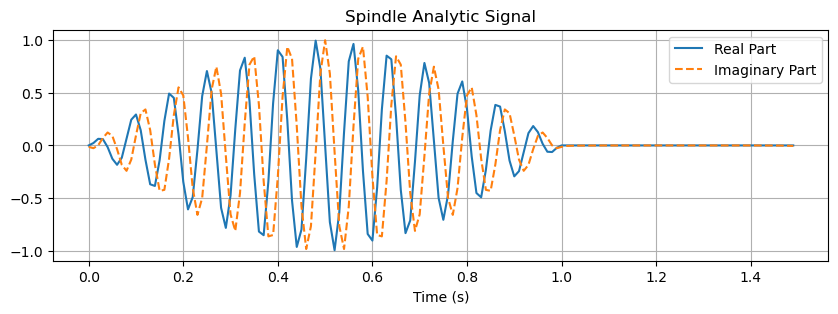

In [ ]:
# Compute Discrete Fourier Transformation
def dft(signal):
    N = len(signal)
    dft_output = np.zeros(N, dtype=complex)
    for k in range(N):  # Loop over frequency bins
        for n in range(N):  # Sum over time samples
            dft_output[k] += signal[n] * np.exp(-2j * np.pi * k * n / N)
    return dft_output

# Compute Inverse Discrete Fourier Transformation
def idft(filtered_signal):
    N = len(filtered_signal)
    idft_output = np.zeros(N, dtype=complex)
    for n in range(N):  # Loop over time samples
        for k in range(N):  # Sum over frequency bins
            idft_output[n] += filtered_signal[k] * np.exp(2j * np.pi * k * n / N)
    return idft_output / N

# Construct Hilbert transform filter
def hilbert_filter(N):
    filter_array = np.zeros(N)
    filter_array[0] = 1  # DC component
    if N % 2 == 0:  # Even-length signal
        filter_array[1:N//2] = 2  # Positive frequencies
        filter_array[N//2] = 1  # Nyquist frequency
    else:  # Odd-length signal
        filter_array[1:(N+1)//2] = 2  # Positive frequencies
    return filter_array

# Apply Hilbert transform
def hilbert_transform(signal):
    N = len(signal)
    fft_signal = dft(signal)  # Convert time domain into frequency domain
    filter_array = hilbert_filter(N)  # Create Hilbert filter
    filtered_signal = fft_signal * filter_array  # Apply the filter
    idft_output = idft(filtered_signal) # Convert back to time domain
    return idft_output

# Simplified implemention
def hilbert_transform_simplified(signal):
    N = len(signal)
    Fx = np.fft.fft(signal)
    f_axis = np.fft.fftfreq(N)
    Fx[f_axis < 0] = 0
    analytic_signal = np.fft.ifft(Fx * 2)
    return analytic_signal

# or directly use scipy.signal.hilbert()

fs = 100
t = np.arange(0, 1, 1/fs)
modulator = np.sin(2 * np.pi * 0.5 * t)  # 0.5 Hz modulator for spindle envelope
spindle = np.sin(2 * np.pi * 13 * t)  # 10-16 Hz spindle
spindle_signal = modulator * spindle
flat_dur = 0.5
t_flat = np.arange(1, 1 + flat_dur, 1/fs)
flat_signal = np.zeros_like(t_flat)
spindle_signal = np.concatenate([spindle_signal, flat_signal])
t = np.concatenate([t, t_flat])

# Perform the Hilbert transform
analytic_signal_SP = hilbert_transform(spindle_signal)
instant_amp_SP = np.abs(analytic_signal_SP)
instant_phase_SP = np.angle(analytic_signal_SP)
print("Analytic Signal (Real + Imaginary Part):")
print([f"{x.real:.6f}{x.imag:+.6f}j" for x in analytic_signal_SP[:5]], "...")
print("Instantaneous phase", instant_phase_SP[:5], "...")
print("Instantaneous amplitude", instant_amp_SP[:5], "...")

plt.figure(figsize=(10, 3))
plt.plot(t, spindle_signal)
plt.title("Spindle Raw Signal")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t, instant_amp_SP, linestyle="--")
plt.title("Spindle Instantaneous Amplitude")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t, instant_phase_SP, linestyle=":")
plt.title("Spindle Instantaneous Phase")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t, analytic_signal_SP.real, label="Real Part")
plt.plot(t, analytic_signal_SP.imag, label="Imaginary Part", linestyle="--")
plt.title("Spindle Analytic Signal")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

Analytic Signal (Real + Imaginary Part):
['0.257330-0.095578j', '0.247337+0.082514j', '0.236508+0.094968j', '0.224850+0.161399j', '0.212375+0.172645j'] ...
Instantaneous phase [-0.35562902  0.32199803  0.38183489  0.62257624  0.68257392] ...
Instantaneous amplitude [0.27450692 0.26073722 0.25486211 0.2767801  0.27369619] ...


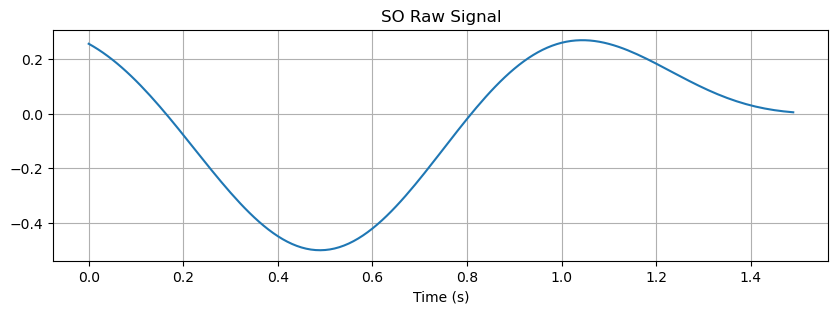

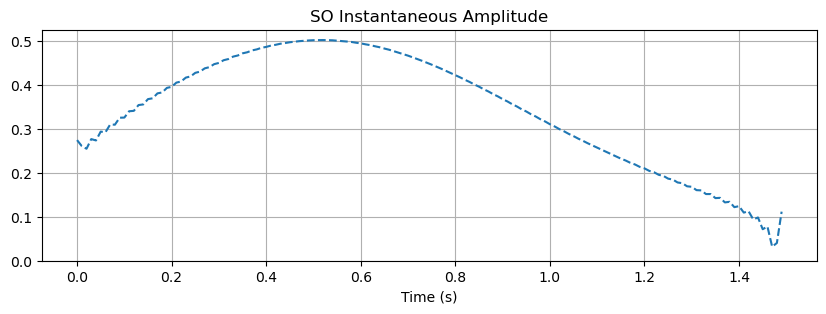

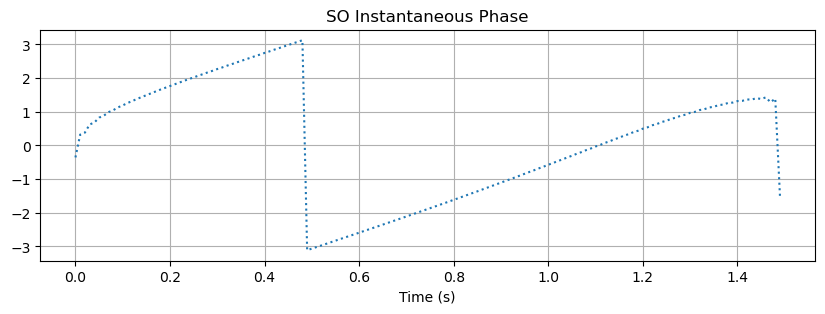

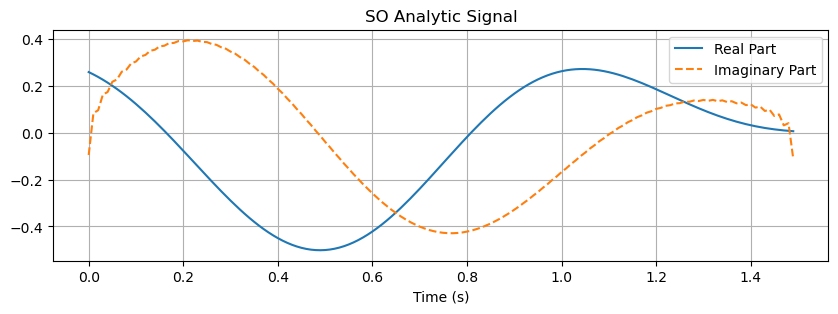

In [ ]:
fs = 100
t = np.arange(0, 2.5, 1/fs)
slow_wave = 0.5 * np.sin(2 * np.pi * 1 * t)  # 1 Hz slow oscillation
t = t[0:int(1.5 * fs)]
slow_wave = slow_wave[int(0.25 * fs):int(1.75 * fs)]

nyquist = fs / 2
low = 0.5 / nyquist
high = 1.25 / nyquist
b, a = butter(2, [low, high], btype='bandpass')
slow_wave = filtfilt(b, a, slow_wave)

# Perform the Hilbert transform
analytic_signal_SO = hilbert_transform(slow_wave)
instant_amp_SO = np.abs(analytic_signal_SO)
instant_phase_SO = np.angle(analytic_signal_SO)

print("Analytic Signal (Real + Imaginary Part):")
print([f"{x.real:.6f}{x.imag:+.6f}j" for x in analytic_signal_SO[:5]], "...")
print("Instantaneous phase", instant_phase_SO[:5], "...")
print("Instantaneous amplitude", instant_amp_SO[:5], "...")

plt.figure(figsize=(10, 3))
plt.plot(t, slow_wave)
plt.title("SO Raw Signal")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t, instant_amp_SO, linestyle="--")
plt.ylim(bottom=0)
plt.title("SO Instantaneous Amplitude")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t, instant_phase_SO, linestyle=":")
plt.title("SO Instantaneous Phase")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t, analytic_signal_SO.real, label="Real Part")
plt.plot(t, analytic_signal_SO.imag, label="Imaginary Part", linestyle="--")
plt.title("SO Analytic Signal")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def generate_spindle(num_iterations=200, fs=100, flat_dur=0.5):
    spindle_signals = {}

    for i in range(num_iterations):
        t_spindle = np.arange(0, 1, 1/fs)
        modulator = np.sin(2 * np.pi * 0.5 * t_spindle)
        spindle = np.sin(2 * np.pi * 13 * t_spindle)
        spindle_signal = modulator * spindle

        flat_before = random.uniform(0, flat_dur)
        flat_after = flat_dur - flat_before
        t_flat_before = np.arange(0, flat_before, 1/fs)
        t_flat_after = np.arange(0, flat_after, 1/fs)
        flat_signal_before = np.zeros_like(t_flat_before)
        flat_signal_after = np.zeros_like(t_flat_after)

        t = np.concatenate([t_flat_before, t_spindle, t_flat_after])
        signal_SP = np.concatenate([flat_signal_before, spindle_signal, flat_signal_after])
        instant_amp_SP = np.abs(analytic_signal_SP)

        spindle_signals[i] = {
            "signal":signal_SP,
            "instant_amp": instant_amp_SP
        }

    return spindle_signals

SP_signals_dict = generate_spindle()

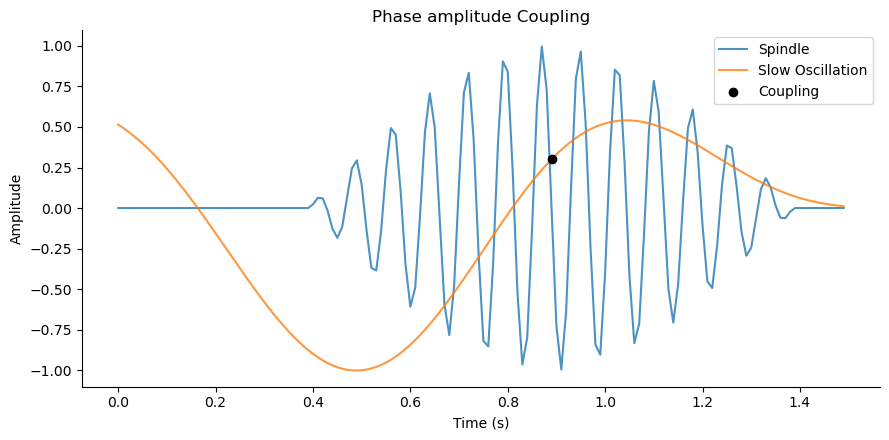

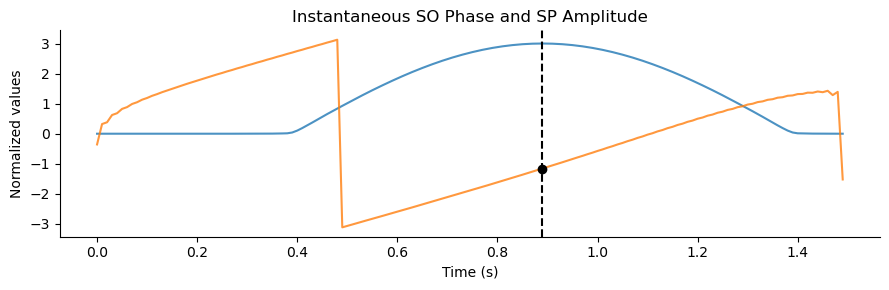

In [230]:
SP_signal = SP_signals_dict[next(iter(SP_signals_dict))]["signal"][0:150]
time = np.arange(len(SP_signal)) / fs
peak_idx = np.argmax(SP_signals_dict[next(iter(SP_signals_dict))]["instant_amp"])
peak_time = time[peak_idx]
peak_amplitude = slow_wave[peak_idx]*2

fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(time, SP_signal, label="Spindle", alpha=0.8)
ax.plot(time, slow_wave*2, label="Slow Oscillation", alpha=0.8)
ax.scatter(peak_time, peak_amplitude, color="black", zorder=5, label="Coupling")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Phase amplitude Coupling")
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

instantaneous_phase_SP = SP_signals_dict[next(iter(SP_signals_dict))]["instant_amp"][0:150]
peak_phase = instant_phase_SO[peak_idx]

fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(time, instantaneous_phase_SP*3, alpha=0.8)
ax.plot(t, instant_phase_SO, alpha=0.8)
ax.set_title("Instantaneous SO Phase and SP Amplitude")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Normalized values")
ax.axvline(x=peak_time, color="black", linestyle="--", linewidth=1.5)
ax.scatter(peak_time, peak_phase, color="black", zorder=5, label="Coupling (SP)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

Preferred Phase:    -1.87 rad
Mean Vector Length:  0.77
Rayleigh z:          117.44
p-value:             0.00


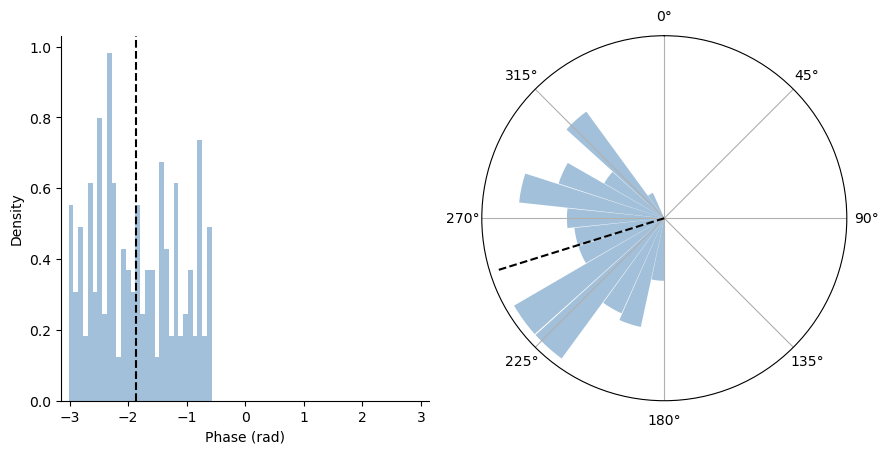

In [ ]:
peaks_so_phase_all = []

for i, spindle in SP_signals_dict.items():
    peaks_idx = np.argmax(spindle["instant_amp"])
    peaks_so_phase = instant_phase_SO[peaks_idx]
    peaks_so_phase_all.append(peaks_so_phase)

pp = np.angle(np.exp(1j * circmean(peaks_so_phase_all)))
mvl = np.abs(np.mean(np.exp(1j * np.array(peaks_so_phase_all))))

print(f"Preferred Phase:    {round(pp, 2)} rad")
print(f"Mean Vector Length:  {round(mvl, 2)}")

## def PAC(phases):
##    sum_sin = np.sum(np.sin(phases))
##    sum_cos = np.sum(np.cos(phases))
##    pp = np.arctan2(sum_sin, sum_cos)
##    mvl = np.sqrt(sum_sin**2 + sum_cos**2) / len(phases)
##    return pp, mvl

def rayleigh_test(phases):
    R = np.abs(np.mean(np.exp(1j * np.array(phases))))
    z = len(phases) * R**2
    p = np.exp(-z) * (1 + z)
    return R, z, p

R, z, p = rayleigh_test(peaks_so_phase_all)

print(f"Rayleigh z:          {z:.2f}")
print(f"p-value:             {p:.2f}")

bins = np.linspace(-np.pi, np.pi, 31)
hist, bin_edges = np.histogram(peaks_so_phase_all, bins=bins, density=True)
theta = (bin_edges[:-1] + bin_edges[1:]) / 2
r = hist

fig = plt.figure(figsize=(9, 4.5))
gs = plt.GridSpec(1, 2, width_ratios=[1, 1])

# Left: Cartesian histogram
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(peaks_so_phase_all, bins=30, density=True, color='#4682B4', alpha=0.5)
ax1.axvline(pp, color='k', linestyle='--')
ax1.set_xlabel("Phase (rad)")
ax1.set_ylabel("Density")
ax1.set_xlim(-np.pi, np.pi)
ax1.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False) 

# Right: Polar plot
ax2 = fig.add_subplot(gs[0, 1], projection='polar')
ax2.bar(theta, r, width=(2 * np.pi / len(bins)), color='#4682B4', alpha=0.5)
ax2.plot([pp, pp], [0, max(r)], color='k', linestyle='--')
ax2.set_yticks([])
ax2.yaxis.set_visible(False)
ax2.set_theta_zero_location("N")
ax2.set_theta_direction(-1)

plt.tight_layout()
plt.show()

Analytic Signal (Real + Imaginary Part):
['0.146409-0.427648j', '0.166994-0.334815j', '0.187436-0.338474j', '0.207655-0.305414j', '0.227566-0.303866j'] ...
Instantaneous phase [-1.24094487 -1.1081378  -1.06506371 -0.97367934 -0.92799719] ...
Instantaneous amplitude [0.45201567 0.37414989 0.38690689 0.36932128 0.37963254] ...


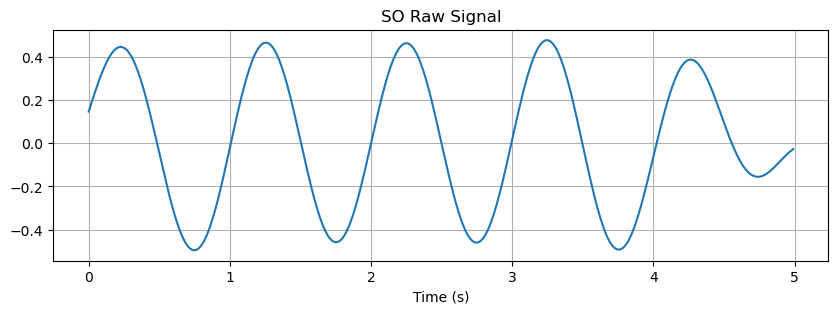

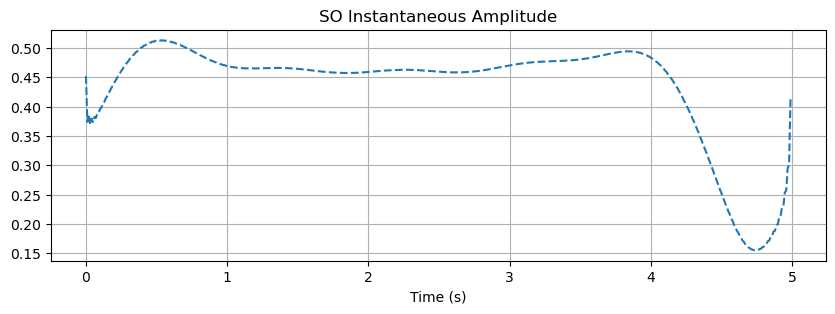

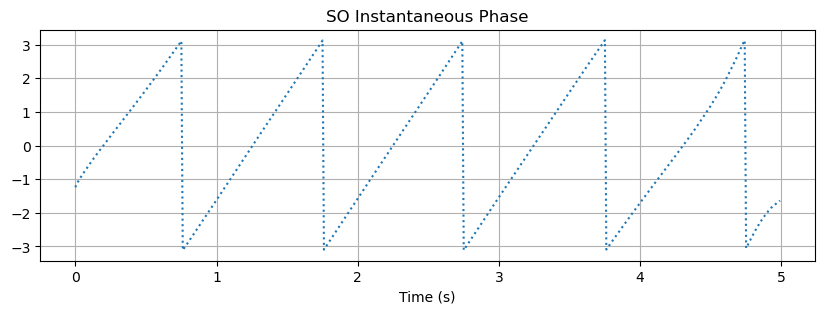

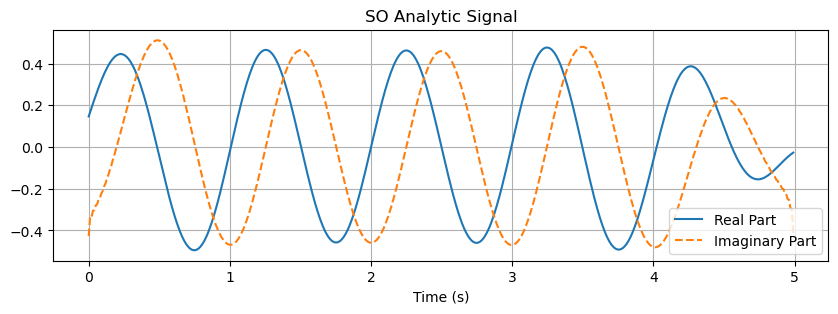

In [232]:
fs = 100
t = np.arange(0, 5, 1/fs)
slow_wave = 0.5 * np.sin(2 * np.pi * 1 * t)  # 1 Hz slow oscillation

nyquist = fs / 2
low = 0.5 / nyquist
high = 1.25 / nyquist
b, a = butter(2, [low, high], btype='bandpass')
slow_wave = filtfilt(b, a, slow_wave)

# Perform the Hilbert transform
analytic_signal_slow = hilbert_transform(slow_wave)
instant_amp_slow = np.abs(analytic_signal_slow)
instant_phase_slow = np.angle(analytic_signal_slow)

print("Analytic Signal (Real + Imaginary Part):")
print([f"{x.real:.6f}{x.imag:+.6f}j" for x in analytic_signal_slow[:5]], "...")
print("Instantaneous phase", instant_phase_slow[:5], "...")
print("Instantaneous amplitude", instant_amp_slow[:5], "...")

plt.figure(figsize=(10, 3))
plt.plot(t, slow_wave)
plt.title("SO Raw Signal")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t, instant_amp_slow, linestyle="--")
plt.title("SO Instantaneous Amplitude")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t, instant_phase_slow, linestyle=":")
plt.title("SO Instantaneous Phase")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t, analytic_signal_slow.real, label="Real Part")
plt.plot(t, analytic_signal_slow.imag, label="Imaginary Part", linestyle="--")
plt.title("SO Analytic Signal")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()